In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

from expected_tackling.data.mott_features import compute_mott_features_data
from expected_tackling.visualization.metrics import plot_confusion_matrix

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
features_data = pd.concat([pd.read_csv(f"../data/features_week_{i}.csv") for i in range(1,10)]).reset_index(drop=True)
tackling_probability = pd.read_csv("../data/tackling_probability.csv")
tackles = pd.read_csv("../data/tackles.csv")

In [5]:
mott_features_data = compute_mott_features_data(features_data, tackling_probability, tackles)

In [6]:
mott_features_data

ott  mean_distance_to_ball_carrier_from_peak  \
gameId     playId nflId                                                        
2022090800 56     38577.0  0.158333                                 1.971121   
                  41239.0  0.000607                                13.907379   
                  42816.0  0.001262                                27.279112   
                  43294.0  1.046483                                 0.670298   
                  43298.0  0.000308                                12.350122   
...                             ...                                      ...   
2022110700 3787   52627.0  0.012055                                13.470441   
                  53460.0  0.115559                                 4.405723   
                  53533.0  0.001109                                19.715603   
                  54541.0  1.136388                                 1.121133   
                  54606.0  0.005385                                12.675541   

                           ball_carrier_distance_won_to_last_frame  \
gameId     playId nflId                                              
2022090800 56     38577.0                                     0.00   
                  41239.0                                     0.00   
                  42816.0                                     0.52   
                  43294.0                                     0.00   
                  43298.0                                     1.15   
...                                                            ...   
2022110700 3787   52627.0                                     5.57   
                  53460.0                                     6.54   
                  53533.0                                     0.00   
                  54541.0                                     1.95   
                  54606.0                                     0.59   

                           tackle_or_assist  pff_missedTackle  
gameId     playId nflId                                        
2022090800 56     38577.0               0.0               0.0  
                  41239.0               0.0               0.0  
                  42816.0               0.0               0.0  
                  43294.0               1.0               0.0  
                  43298.0               0.0               0.0  
...                                     ...               ...  
2022110700 3787   52627.0               0.0               0.0  
                  53460.0               0.0               0.0  
                  53533.0               0.0               0.0  
                  54541.0               0.0               0.0  
                  54606.0               0.0               0.0  

[127941 rows x 5 columns]

In [7]:
sample_mott_features_data = pd.concat([
    mott_features_data[(mott_features_data["pff_missedTackle"]==1)&(mott_features_data["ott"]>0.1)],
    mott_features_data[mott_features_data["pff_missedTackle"]==0].sample(
        len(mott_features_data[mott_features_data["pff_missedTackle"]==1])*10
    )
])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from catboost import CatBoostClassifier

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    sample_mott_features_data.drop(columns=["pff_missedTackle"]), 
    sample_mott_features_data["pff_missedTackle"], 
    test_size=0.33, 
    random_state=42
)

In [10]:
model = CatBoostClassifier(max_depth=2, scale_pos_weight=5, verbose=0)
model.fit(X_train, y_train)

In [11]:
y_pred = model.predict(X_test)

In [12]:
y_test.sum()/len(y_test)

0.08416188208934323

In [13]:
y_pred.sum()/len(y_pred)

0.10586752555664473

In [14]:
balanced_accuracy_score(y_train, model.predict(X_train))

0.9437096945165531

In [15]:
balanced_accuracy_score(y_test, y_pred)

0.9418214800002035

In [16]:
confusion_matrix(y_train, model.predict(X_train))

array([[12767,   413],
       [  107,  1210]], dtype=int64)

In [17]:
confusion_matrix(y_test, y_pred)

array([[6334,  206],
       [  51,  550]], dtype=int64)

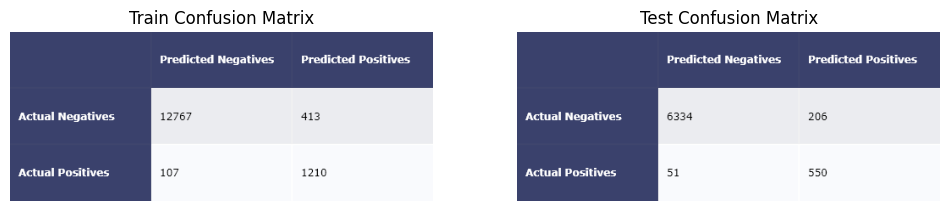

In [20]:
plot_confusion_matrix(
    confusion_matrix(y_train, model.predict(X_train)), 
    confusion_matrix(y_test, y_pred),
    name="mott_confusion_matrix"
)

In [21]:
import pickle
pickle.dump(model, open("../models/model_mott.pkl", 'wb'))

In [22]:
mott_features_data.to_csv("../data/features_mott.csv")

In [23]:
result_data = mott_features_data.copy()
result_data["prediction"] = model.predict(result_data.drop(columns=["pff_missedTackle"]))

In [24]:
result_data

ott  mean_distance_to_ball_carrier_from_peak  \
gameId     playId nflId                                                        
2022090800 56     38577.0  0.158333                                 1.971121   
                  41239.0  0.000607                                13.907379   
                  42816.0  0.001262                                27.279112   
                  43294.0  1.046483                                 0.670298   
                  43298.0  0.000308                                12.350122   
...                             ...                                      ...   
2022110700 3787   52627.0  0.012055                                13.470441   
                  53460.0  0.115559                                 4.405723   
                  53533.0  0.001109                                19.715603   
                  54541.0  1.136388                                 1.121133   
                  54606.0  0.005385                                12.675541   

                           ball_carrier_distance_won_to_last_frame  \
gameId     playId nflId                                              
2022090800 56     38577.0                                     0.00   
                  41239.0                                     0.00   
                  42816.0                                     0.52   
                  43294.0                                     0.00   
                  43298.0                                     1.15   
...                                                            ...   
2022110700 3787   52627.0                                     5.57   
                  53460.0                                     6.54   
                  53533.0                                     0.00   
                  54541.0                                     1.95   
                  54606.0                                     0.59   

                           tackle_or_assist  pff_missedTackle  prediction  
gameId     playId nflId                                                    
2022090800 56     38577.0               0.0               0.0         0.0  
                  41239.0               0.0               0.0         0.0  
                  42816.0               0.0               0.0         0.0  
                  43294.0               1.0               0.0         0.0  
                  43298.0               0.0               0.0         0.0  
...                                     ...               ...         ...  
2022110700 3787   52627.0               0.0               0.0         0.0  
                  53460.0               0.0               0.0         0.0  
                  53533.0               0.0               0.0         0.0  
                  54541.0               0.0               0.0         1.0  
                  54606.0               0.0               0.0         0.0  

[127941 rows x 6 columns]

In [25]:
result_data.loc[(2022100911,2915)]

,ott,mean_distance_to_ball_carrier_from_peak,ball_carrier_distance_won_to_last_frame,tackle_or_assist,pff_missedTackle,prediction
nflId,,,,,,
42401.0,0.000421,19.369486,7.07,0.0,0.0,0.0
43986.0,0.795232,4.820028,6.44,0.0,1.0,1.0
44848.0,0.018716,8.442979,1.66,0.0,0.0,0.0
47816.0,1.076127,3.278709,5.02,1.0,0.0,1.0
47848.0,0.001377,16.561179,7.89,0.0,0.0,0.0
49410.0,0.012372,9.991531,3.07,0.0,0.0,0.0
52416.0,0.605927,2.162725,3.48,0.0,0.0,1.0
52522.0,0.003440,10.140932,7.43,0.0,0.0,0.0
53445.0,0.032192,5.606291,0.00,0.0,0.0,0.0
